In [9]:
# Cell 1: Imports & basic setup

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make sure plots show inside the notebook
%matplotlib inline

# Create required folders for the assignment
os.makedirs('/content/outputs', exist_ok=True)
os.makedirs('/content/csv_files', exist_ok=True)

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)


In [10]:
# Cell 2: Load raw CSV files

# Change the paths here if your files are in another location
hist_path = '/content/historical_data.csv'
fg_path   = '/content/fear_greed_index.csv'

hist_df = pd.read_csv(hist_path)
fg_df   = pd.read_csv(fg_path)

print("Historical data shape:", hist_df.shape)
print("Fear & Greed data shape:", fg_df.shape)

print("\nHistorical columns:\n", hist_df.columns)
print("\nFear & Greed columns:\n", fg_df.columns)


Historical data shape: (211224, 16)
Fear & Greed data shape: (2644, 4)

Historical columns:
 Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position',
       'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp'],
      dtype='object')

Fear & Greed columns:
 Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [11]:
# Cell 3: Quick overview of raw data

print("=== Historical data preview ===")
display(hist_df.head())

print("\n=== Fear & Greed data preview ===")
display(fg_df.head())

print("\nMissing values in historical data:")
display(hist_df.isna().sum())

print("\nMissing values in Fear & Greed data:")
display(fg_df.isna().sum())


=== Historical data preview ===


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12



=== Fear & Greed data preview ===


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05



Missing values in historical data:


,0
Account,0
Coin,0
Execution Price,0
Size Tokens,0
Size USD,0
Side,0
Timestamp IST,0
Start Position,0
Direction,0
Closed PnL,0



Missing values in Fear & Greed data:


,0
timestamp,0
value,0
classification,0
date,0


In [12]:
# Cell 4: Preprocess Fear & Greed data

fg_df = fg_df.copy()

# Ensure timestamp / date columns are usable
fg_df['timestamp'] = pd.to_datetime(fg_df['timestamp'], errors='coerce', unit='s')  # many F&G datasets use unix seconds
fg_df['date'] = pd.to_datetime(fg_df['date'], errors='coerce')

# Use 'date' as the official sentiment date (day-level)
fg_df['fg_date'] = fg_df['date'].dt.date

# Rename classification -> Sentiment
fg_df = fg_df.rename(columns={'classification': 'Sentiment', 'value': 'fg_score'})

# Keep only the columns we need for merge + info
fg_clean = fg_df[['fg_date', 'Sentiment', 'fg_score']].drop_duplicates()

print("Unique sentiments:", fg_clean['Sentiment'].unique())
display(fg_clean.head())


Unique sentiments: ['Fear' 'Extreme Fear' 'Neutral' 'Greed' 'Extreme Greed']


,fg_date,Sentiment,fg_score
0,2018-02-01,Fear,30
1,2018-02-02,Extreme Fear,15
2,2018-02-03,Fear,40
3,2018-02-04,Extreme Fear,24
4,2018-02-05,Extreme Fear,11


In [13]:
# Cell 5: Preprocess historical trades

hist_df = hist_df.copy()

# Convert timestamps
# Primary: 'Timestamp IST'
if 'Timestamp IST' in hist_df.columns:
    hist_df['Timestamp IST'] = pd.to_datetime(hist_df['Timestamp IST'], errors='coerce')
else:
    hist_df['Timestamp IST'] = pd.NaT

# Fallback: numeric 'Timestamp' if available (e.g., unix)
if 'Timestamp' in hist_df.columns:
    # Try to parse as unix seconds; if wrong scale, adjust manually
    try:
        ts = pd.to_datetime(hist_df['Timestamp'], unit='ms', errors='coerce')
        # if almost all are NaT, try seconds instead
        if ts.isna().mean() > 0.9:
            ts = pd.to_datetime(hist_df['Timestamp'], unit='s', errors='coerce')
        hist_df['Timestamp_parsed'] = ts
    except Exception as e:
        print("Warning parsing numeric Timestamp:", e)
        hist_df['Timestamp_parsed'] = pd.NaT
else:
    hist_df['Timestamp_parsed'] = pd.NaT

# Final unified timestamp
hist_df['trade_ts'] = hist_df['Timestamp IST'].fillna(hist_df['Timestamp_parsed'])

# Trade date (for merging with F&G)
hist_df['trade_date'] = hist_df['trade_ts'].dt.date

# Convert numeric columns
for col in ['Closed PnL', 'Size USD', 'Size Tokens']:
    if col in hist_df.columns:
        hist_df[col] = pd.to_numeric(hist_df[col], errors='coerce')

# Basic engineered features
hist_df['NotionalUSD'] = hist_df['Size USD']  # alias for clarity
hist_df['is_win'] = hist_df['Closed PnL'] > 0

print("After preprocessing, historical data:")
display(hist_df[['Account', 'Coin', 'Closed PnL', 'Size USD', 'trade_ts', 'trade_date']].head())

# Save cleaned version
hist_df.to_csv('/content/csv_files/historical_data_clean.csv', index=False)
fg_clean.to_csv('/content/csv_files/fear_greed_clean.csv', index=False)


After preprocessing, historical data:


,Account,Coin,Closed PnL,Size USD,trade_ts,trade_date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,0.0,7872.16,2024-02-12 22:50:00,2024-02-12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,0.0,127.68,2024-02-12 22:50:00,2024-02-12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,0.0,1150.63,2024-02-12 22:50:00,2024-02-12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,0.0,1142.04,2024-02-12 22:50:00,2024-02-12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,0.0,69.75,2024-02-12 22:50:00,2024-02-12


In [14]:
# Cell 6: Merge trades with Fear & Greed sentiment

merged_df = pd.merge(
    hist_df,
    fg_clean,
    how='left',
    left_on='trade_date',
    right_on='fg_date'
)

print("Merged shape:", merged_df.shape)
print("Rows with missing Sentiment:", merged_df['Sentiment'].isna().sum())

display(merged_df[['Account', 'Coin', 'Closed PnL', 'NotionalUSD', 'trade_ts', 'Sentiment']].head())

# Save merged version
merged_df.to_csv('/content/csv_files/merged_trades_sentiment.csv', index=False)


Merged shape: (211224, 24)
Rows with missing Sentiment: 69092


,Account,Coin,Closed PnL,NotionalUSD,trade_ts,Sentiment
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,0.0,7872.16,2024-02-12 22:50:00,Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,0.0,127.68,2024-02-12 22:50:00,Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,0.0,1150.63,2024-02-12 22:50:00,Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,0.0,1142.04,2024-02-12 22:50:00,Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,0.0,69.75,2024-02-12 22:50:00,Greed


In [15]:
# Cell 7: Summary stats by sentiment

valid_sent_mask = merged_df['Sentiment'].notna()

sentiment_stats = (
    merged_df[valid_sent_mask]
    .groupby('Sentiment')
    .agg(
        avg_pnl=('Closed PnL', 'mean'),
        median_pnl=('Closed PnL', 'median'),
        trades=('Closed PnL', 'size'),
        win_rate=('is_win', 'mean'),
        avg_notional_usd=('NotionalUSD', 'mean')
    )
    .sort_values('avg_pnl', ascending=False)
)

print("Summary stats by sentiment:")
display(sentiment_stats)

# Save summary to CSV (for report / GitHub)
sentiment_stats.to_csv('/content/csv_files/sentiment_stats_by_sentiment.csv')


Summary stats by sentiment:


,avg_pnl,median_pnl,trades,win_rate,avg_notional_usd
Sentiment,,,,,
Extreme Greed,127.039766,0.319072,9539,0.531502,4078.957461
Greed,62.688600,0.000000,37270,0.429568,3628.829843
Fear,50.688930,0.000000,85784,0.411219,4617.698993
Neutral,45.015158,0.000000,7213,0.395952,3518.800427
Extreme Fear,1.891632,0.000000,2326,0.292777,4118.761840


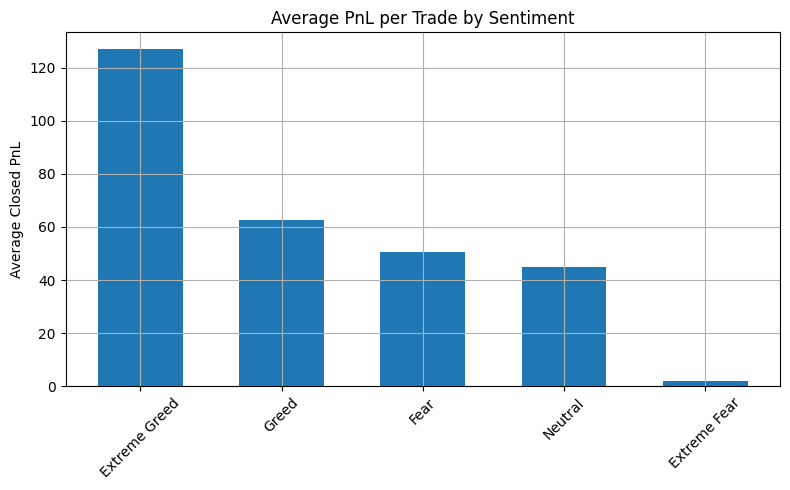

In [16]:
# Cell 8: Average PnL per Trade by Sentiment (bar chart)

plt.figure(figsize=(8, 5))

x = np.arange(len(sentiment_stats.index))
y = sentiment_stats['avg_pnl'].values

plt.bar(x, y, width=0.6)

plt.xticks(x, sentiment_stats.index, rotation=45)
plt.ylabel('Average Closed PnL')
plt.title('Average PnL per Trade by Sentiment')

plt.tight_layout()
plt.savefig('/content/outputs/avg_pnl_by_sentiment.png', bbox_inches='tight')
plt.show()


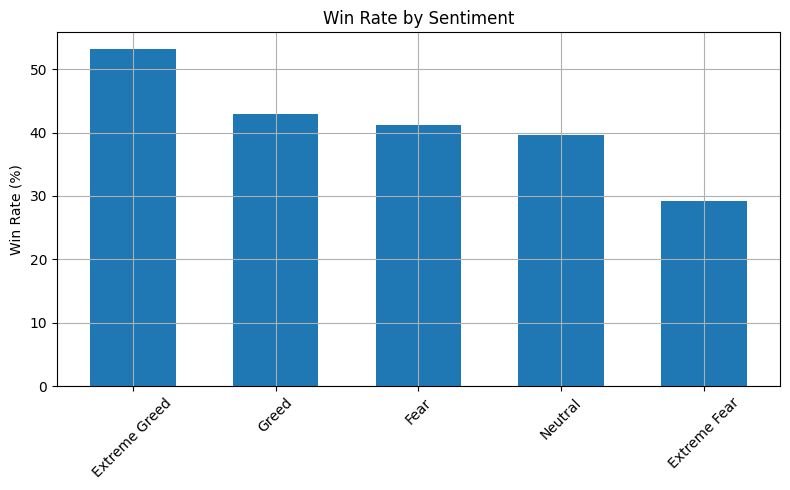

In [17]:
# Cell 9: Win Rate by Sentiment

plt.figure(figsize=(8, 5))

x = np.arange(len(sentiment_stats.index))
y = (sentiment_stats['win_rate'] * 100).values  # percent

plt.bar(x, y, width=0.6)

plt.xticks(x, sentiment_stats.index, rotation=45)
plt.ylabel('Win Rate (%)')
plt.title('Win Rate by Sentiment')

plt.tight_layout()
plt.savefig('/content/outputs/win_rate_by_sentiment.png', bbox_inches='tight')
plt.show()


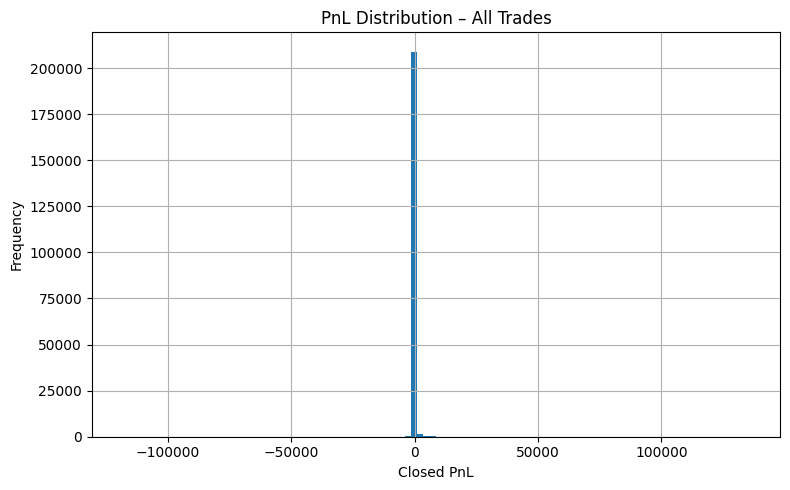

In [18]:
# Cell 10: PnL distribution (all trades)

plt.figure(figsize=(8, 5))
clean_pnl = merged_df['Closed PnL'].dropna()

plt.hist(clean_pnl, bins=100)
plt.xlabel('Closed PnL')
plt.ylabel('Frequency')
plt.title('PnL Distribution – All Trades')

plt.tight_layout()
plt.savefig('/content/outputs/pnl_distribution_all.png', bbox_inches='tight')
plt.show()


In [19]:
# Cell 11: Average leverage by Sentiment (if leverage exists)

if 'leverage' in merged_df.columns:
    merged_df['leverage'] = pd.to_numeric(merged_df['leverage'], errors='coerce')

    lev_stats = (
        merged_df[valid_sent_mask]
        .groupby('Sentiment')
        .agg(avg_leverage=('leverage', 'mean'),
             median_leverage=('leverage', 'median'))
        .sort_values('avg_leverage', ascending=False)
    )

    display(lev_stats)
    lev_stats.to_csv('/content/csv_files/leverage_by_sentiment.csv')

    plt.figure(figsize=(8, 5))
    x = np.arange(len(lev_stats.index))
    plt.bar(x, lev_stats['avg_leverage'].values, width=0.6)
    plt.xticks(x, lev_stats.index, rotation=45)
    plt.ylabel('Average Leverage')
    plt.title('Average Leverage by Sentiment')
    plt.tight_layout()
    plt.savefig('/content/outputs/avg_leverage_by_sentiment.png', bbox_inches='tight')
    plt.show()

else:
    print("Column 'leverage' not found in historical_data.csv – skipping leverage analysis.")


Column 'leverage' not found in historical_data.csv – skipping leverage analysis.


In [20]:
# Cell 12: Coin-level performance

coin_stats = (
    merged_df[valid_sent_mask]
    .groupby(['Coin', 'Sentiment'])
    .agg(
        total_pnl=('Closed PnL', 'sum'),
        trades=('Closed PnL', 'size'),
        win_rate=('is_win', 'mean')
    )
    .reset_index()
)

coin_stats.to_csv('/content/csv_files/coin_stats_by_sentiment.csv', index=False)

display(coin_stats.head())

# Top 10 coins by total PnL overall
top_coins = (
    merged_df.groupby('Coin')['Closed PnL']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
print("Top 10 coins by total PnL:")
display(top_coins)


,Coin,Sentiment,total_pnl,trades,win_rate
0,@1,Fear,66.390428,8,0.375
1,@1,Greed,430.355810,25,0.400
2,@10,Fear,0.000000,1,0.000
3,@10,Greed,-0.063484,2,0.000
4,@10,Neutral,0.000000,1,0.000


Top 10 coins by total PnL:


,Closed PnL
Coin,
@107,2.783913e+06
HYPE,1.948485e+06
SOL,1.639556e+06
ETH,1.319979e+06
BTC,8.680447e+05
MELANIA,3.903511e+05
ENA,2.173295e+05
SUI,1.992688e+05
ZRO,1.837778e+05


Top 10 accounts by total PnL:


,total_pnl,trades,win_rate,avg_notional_usd
Account,,,,
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,2.143383e+06,14733,0.337134,3837.885375
0x083384f897ee0f19899168e3b1bec365f52a9012,1.600230e+06,3818,0.359612,16159.576734
0xbaaaf6571ab7d571043ff1e313a9609a10637864,9.401638e+05,21192,0.467582,3210.472831
0x513b8629fe877bb581bf244e326a047b249c4ff1,8.404226e+05,12236,0.401193,34396.580284
0xbee1707d6b44d4d52bfe19e41f8a828645437aab,8.360806e+05,40184,0.428230,1844.211886
0x4acb90e786d897ecffb614dc822eb231b4ffb9f4,6.777471e+05,4356,0.486226,9084.699093
0x72743ae2822edd658c0c50608fd7c5c501b2afbd,4.293556e+05,1590,0.345912,7216.667245
0x430f09841d65beb3f27765503d0f850b8bce7713,4.165419e+05,1237,0.484236,2397.824753
0x72c6a4624e1dffa724e6d00d64ceae698af892a0,4.030115e+05,1430,0.306294,2133.667364


Bottom 10 accounts by total PnL:


,total_pnl,trades,win_rate,avg_notional_usd
Account,,,,
0x8170715b3b381dffb7062c0298972d4727a0a63b,-167621.124781,4601,0.382743,2204.685531
0x271b280974205ca63b716753467d5a371de622ab,-70436.191318,3809,0.301917,8893.000898
0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,-31203.599986,815,0.455215,1729.941104
0x39cef799f8b69da1995852eea189df24eb5cae3c,14456.919336,3589,0.327668,4790.575486
0x7f4f299f74eec87806a830e3caa9afa5f2b9db8f,14900.443047,1559,0.452213,3748.867511
0xaf40fdc468c30116bd3307bcbf4a451a7ebf1deb,21758.831753,534,0.322097,8330.193371
0xb899e522b5715391ae1d4f137653e7906c5e2115,22488.500821,4838,0.438611,22504.555829
0x8477e447846c758f5a675856001ea72298fd9cb5,43917.008976,14998,0.261968,820.428513
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,47885.320514,7280,0.442720,1653.226327


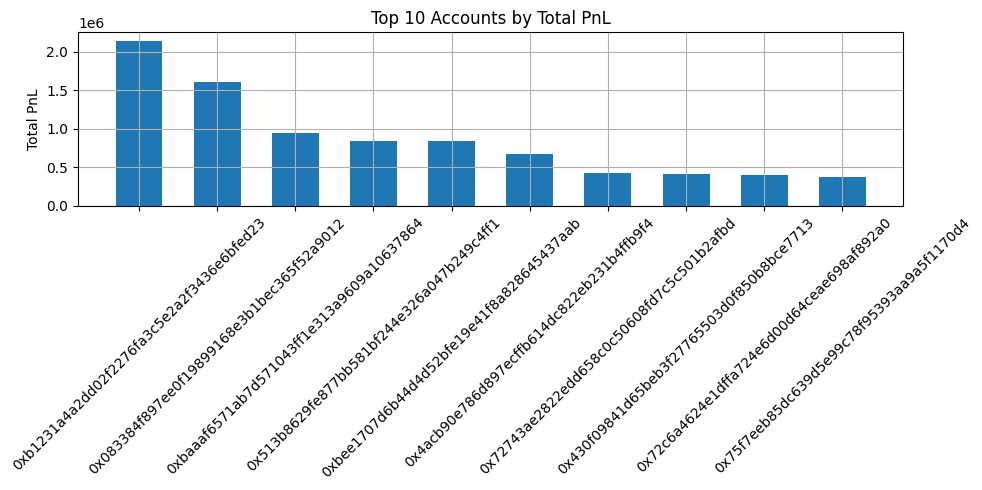

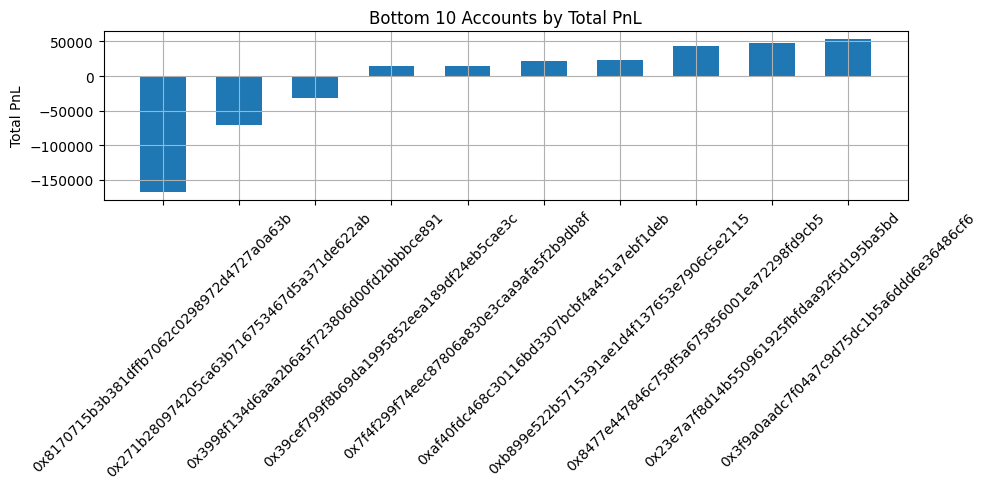

In [21]:
# Cell 13: Top vs Bottom traders (accounts)

account_stats = (
    merged_df.groupby('Account')
    .agg(
        total_pnl=('Closed PnL', 'sum'),
        trades=('Closed PnL', 'size'),
        win_rate=('is_win', 'mean'),
        avg_notional_usd=('NotionalUSD', 'mean')
    )
)

account_stats.to_csv('/content/csv_files/account_stats_overall.csv')

top_accounts = account_stats.sort_values('total_pnl', ascending=False).head(10)
bottom_accounts = account_stats.sort_values('total_pnl', ascending=True).head(10)

print("Top 10 accounts by total PnL:")
display(top_accounts)

print("Bottom 10 accounts by total PnL:")
display(bottom_accounts)

# Simple bar chart for top vs bottom (total PnL)
plt.figure(figsize=(10, 5))
plt.bar(top_accounts.index.astype(str), top_accounts['total_pnl'].values, width=0.6)
plt.xticks(rotation=45)
plt.ylabel('Total PnL')
plt.title('Top 10 Accounts by Total PnL')
plt.tight_layout()
plt.savefig('/content/outputs/top_accounts_total_pnl.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(bottom_accounts.index.astype(str), bottom_accounts['total_pnl'].values, width=0.6)
plt.xticks(rotation=45)
plt.ylabel('Total PnL')
plt.title('Bottom 10 Accounts by Total PnL')
plt.tight_layout()
plt.savefig('/content/outputs/bottom_accounts_total_pnl.png', bbox_inches='tight')
plt.show()


In [23]:
# Cell 14: Summary of outputs

print("All done")
print("Clean CSVs saved in: /content/csv_files")
print("Charts saved in:      /content/outputs")


All done
Clean CSVs saved in: /content/csv_files
Charts saved in:      /content/outputs
